<a href="https://colab.research.google.com/github/asiabak/Licencjat-modele/blob/main/SVM_z_wykresami_i_matrycami_pomy%C5%82ek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim scikit-learn nltk pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 re

In [1]:
# First, verify GPU is available in Colab
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Install necessary libraries if not already available
# !pip install gensim scikit-learn nltk pandas

import urllib.request
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from gensim.models import FastText
import tensorflow as tf
import time
import os

# Use GPU for tensor operations
with tf.device('/GPU:0'):
    # Download NLTK data if needed
    nltk.download('punkt_tab')

    # # Set up paths for KGR10 FastText model
    # model_url = "https://huggingface.co/clarin-pl/fasttext-kgr10/resolve/main/kgr10.plain.skipgram.dim100.neg10.bin"
    model_path = "kgr10.plain.skipgram.dim100.neg10.bin"

    # # Download model if it doesn't exist
    # if not os.path.exists(model_path):
    #     print(f"Downloading KGR10 FastText model from {model_url}...")
    #     urllib.request.urlretrieve(model_url, model_path)
    #     print("Download complete!")
    # else:
    #     print(f"Using existing model at {model_path}")

    # Load the FastText model
    print("Loading KGR10 FastText model...")
    model = FastText.load_fasttext_format(model_path)
    print(f"Model loaded! Vector size: {model.vector_size}")

    # Load datasets
    print("Loading datasets...")
    reviews = pd.read_csv("polemo2.0_good_labels.csv")
    reviews_with_idioms = pd.read_csv('polemo2.0_i_idiomy.csv')
    print(f"Loaded {len(reviews)} reviews and {len(reviews_with_idioms)} reviews with idioms")

    # Text preprocessing
    def preprocess_text(text):
        # Handle NaN values
        if isinstance(text, float) and np.isnan(text):
            return ""

        text = str(text).lower()
        text = re.sub(r'[^\w\s]', '', text)
        words = text.split()
        return ' '.join(words)

    # Apply text preprocessing
    print("Preprocessing text...")
    reviews['review_processed'] = reviews['review'].apply(preprocess_text)
    reviews_with_idioms['review_processed'] = reviews_with_idioms['review'].apply(preprocess_text)

    # GPU-accelerated vectorization with TensorFlow
    def vectorize_review_batch(texts, model):
        # Function to get embeddings for one text
        def get_embeddings(text):
            if not text:  # Handle empty strings
                return np.zeros(model.vector_size)

            words = word_tokenize(text.lower())
            word_vectors = []
            for word in words:
                try:
                    # Get vector for the word
                    word_vectors.append(model.wv[word])
                except KeyError:
                    # Skip words not in vocabulary
                    continue

            if word_vectors:
                # Convert to tensor and compute mean
                vectors_tensor = tf.convert_to_tensor(word_vectors, dtype=tf.float32)
                return tf.reduce_mean(vectors_tensor, axis=0).numpy()
            else:
                return np.zeros(model.vector_size)

        # Process each text in the batch
        return [get_embeddings(text) for text in texts]

    # Process reviews in batches to utilize GPU efficiently
    def process_in_batches(df, batch_size=128):
        vectors = []
        start_time = time.time()

        for i in range(0, len(df), batch_size):
            batch_texts = df['review_processed'].iloc[i:i+batch_size].values
            batch_vectors = vectorize_review_batch(batch_texts, model)
            vectors.extend(batch_vectors)

            # Print progress
            if (i+batch_size) % 1000 == 0 or i+batch_size >= len(df):
                elapsed = time.time() - start_time
                print(f"Processed {i+len(batch_texts)}/{len(df)} reviews in {elapsed:.2f} seconds")

        return vectors

    # Create vectors with GPU acceleration
    print("Vectorizing reviews using GPU...")
    reviews_vectors = process_in_batches(reviews)
    reviews_with_idioms_vectors = process_in_batches(reviews_with_idioms)

    # Store vectors in the dataframes
    reviews['vector'] = reviews_vectors
    reviews_with_idioms['vector'] = reviews_with_idioms_vectors

# Prepare data for training (back on CPU for scikit-learn)
print("Preparing data for SVM training...")
X = np.vstack(reviews['vector'].values)
y = reviews['sentiment'].values
X2 = np.vstack(reviews_with_idioms['vector'].values)
y2 = reviews_with_idioms['sentiment'].values


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-1-9e12659d6fda>:41: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  model = FastText.load_fasttext_format(model_path)


Loading KGR10 FastText model...
Model loaded! Vector size: 100
Loading datasets...
Loaded 5264 reviews and 5764 reviews with idioms
Preprocessing text...
Vectorizing reviews using GPU...
Processed 5264/5264 reviews in 13.78 seconds
Processed 5764/5764 reviews in 13.37 seconds
Preparing data for SVM training...


In [ ]:
# # Split into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12)
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=None, random_state=12)

# # Train model on reviews only
# print("Training SVM on reviews dataset...")
# start_time = time.time()
# model_svc = SVC(kernel='poly')
# model_svc.fit(X_train, y_train)
# print(f"SVM training completed in {time.time() - start_time:.2f} seconds")

# # Predict and evaluate
# y_pred = model_svc.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy for model trained on reviews only: {accuracy}")

# # Train model on reviews + idioms
# print("Training SVM on reviews + idioms dataset...")
# start_time = time.time()
# model_svc_idioms = SVC(kernel='poly')
# model_svc_idioms.fit(X2_train, y2_train)
# print(f"SVM training completed in {time.time() - start_time:.2f} seconds")

# # Predict and evaluate
# y2_pred = model_svc_idioms.predict(X_test)
# accuracy2 = accuracy_score(y_test, y2_pred)
# print(f"Accuracy for model trained on reviews + idioms: {accuracy2}")

# # Compare model performance
# print("\nModel Performance Comparison:")
# print(f"Reviews Only:        {accuracy:.4f}")
# print(f"Reviews with Idioms: {accuracy2:.4f}")
# print(f"Improvement:         {(accuracy2-accuracy)*100:.2f}%")



# # # Save models if needed
# # import joblib
# # joblib.dump(model_svc, 'svm_model_reviews_kgr10.pkl')
# # joblib.dump(model_svc_idioms, 'svm_model_reviews_idioms_kgr10.pkl')

Training SVM on reviews dataset...
SVM training completed in 0.71 seconds
Accuracy for model trained on reviews only: 0.5556978233034571
Training SVM on reviews + idioms dataset...
SVM training completed in 0.80 seconds
Accuracy for model trained on reviews + idioms: 0.5224071702944942

Model Performance Comparison:
Reviews Only:        0.5557
Reviews with Idioms: 0.5224
Improvement:         -3.33%


['svm_model_reviews_idioms_kgr10.pkl']


Training SVM (kernel=linear) on reviews only...
Done in 2.05s, Accuracy: 0.5772
Training SVM (kernel=linear) on reviews + idioms...
Done in 3.46s, Accuracy: 0.5803

Training SVM (kernel=poly) on reviews only...
Done in 2.07s, Accuracy: 0.5757
Training SVM (kernel=poly) on reviews + idioms...
Done in 2.68s, Accuracy: 0.5739

Training SVM (kernel=rbf) on reviews only...
Done in 2.97s, Accuracy: 0.5673
Training SVM (kernel=rbf) on reviews + idioms...
Done in 7.28s, Accuracy: 0.5696


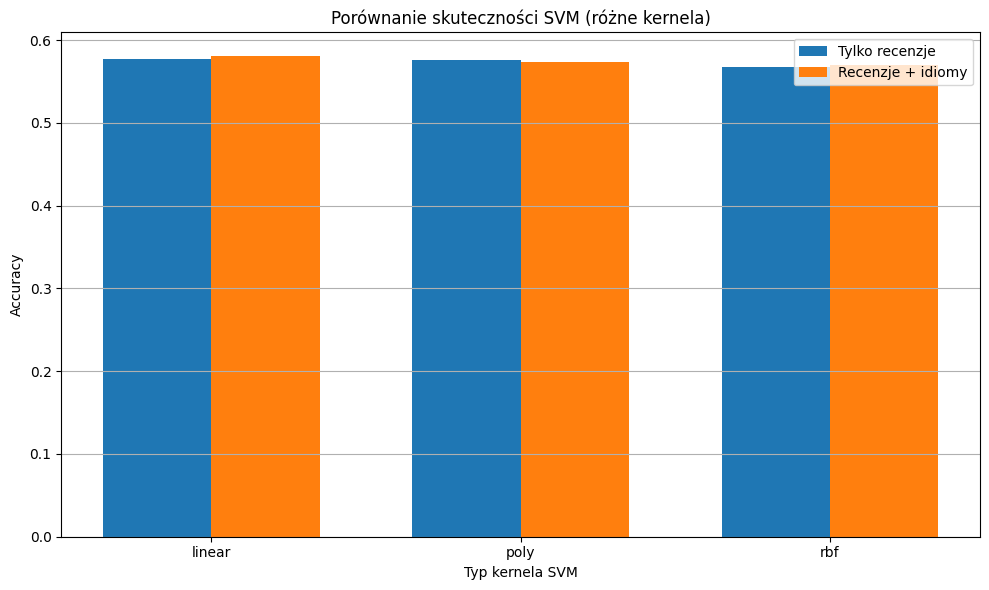

NameError: name 'confusion_matrices_reviews' is not defined

In [6]:
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# import numpy as np
# import time
# import seaborn as sns


# # Podział danych
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=12)

# # Lista kernelów do przetestowania
# kernels = ['linear', 'poly', 'rbf']

# # Miejsce na accuracy
# acc_reviews = []
# acc_reviews_idioms = []

# # Trenowanie i zbieranie wyników
# for kernel in kernels:
#     print(f"\nTraining SVM (kernel={kernel}) on reviews only...")
#     model = SVC(kernel=kernel)
#     start = time.time()
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)
#     acc_reviews.append(acc)
#     print(f"Done in {time.time() - start:.2f}s, Accuracy: {acc:.4f}")

#     print(f"Training SVM (kernel={kernel}) on reviews + idioms...")
#     model2 = SVC(kernel=kernel)
#     start = time.time()
#     model2.fit(X2_train, y2_train)
#     y2_pred = model2.predict(X2_test)
#     acc2 = accuracy_score(y2_test, y2_pred)
#     acc_reviews_idioms.append(acc2)
#     print(f"Done in {time.time() - start:.2f}s, Accuracy: {acc2:.4f}")

# # Wykres porównawczy
# x = np.arange(len(kernels))
# width = 0.35

# fig, ax = plt.subplots(figsize=(10,6))
# bars1 = ax.bar(x - width/2, acc_reviews, width, label='Tylko recenzje')
# bars2 = ax.bar(x + width/2, acc_reviews_idioms, width, label='Recenzje + idiomy')

# ax.set_xlabel('Typ kernela SVM')
# ax.set_ylabel('Accuracy')
# ax.set_title('Porównanie skuteczności SVM (różne kernela)')
# ax.set_xticks(x)
# ax.set_xticklabels(kernels)
# ax.legend()
# ax.grid(True, axis='y')
# plt.tight_layout()
# plt.show()

# # Funkcja do rysowania macierzy pomyłek
# def plot_confusion_matrices(cm_reviews, cm_idioms, kernel_name):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#     # Macierz dla "tylko recenzje"
#     sns.heatmap(cm_reviews, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1],
#                 ax=ax1, cbar_kws={'label': 'Liczba przypadków'})
#     ax1.set_title(f'Tylko recenzje - {kernel_name}')
#     ax1.set_xlabel('Przewidywane etykiety')
#     ax1.set_ylabel('Rzeczywiste etykiety')

#     # Macierz dla "recenzje + idiomy"
#     sns.heatmap(cm_idioms, annot=True, fmt='d', cmap='Greens',
#                 xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1],
#                 ax=ax2, cbar_kws={'label': 'Liczba przypadków'})
#     ax2.set_title(f'Recenzje + idiomy - {kernel_name}')
#     ax2.set_xlabel('Przewidywane etykiety')
#     ax2.set_ylabel('Rzeczywiste etykiety')

#     plt.tight_layout()
#     plt.show()

# # Wyświetlenie macierzy pomyłek dla każdego kernela
# for i, kernel in enumerate(kernels):
#     plot_confusion_matrices(confusion_matrices_reviews[i],
#                           confusion_matrices_idioms[i],
#                           kernel.upper())

# # Opcjonalnie: zestawienie wszystkich macierzy na jednym wykresie
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# fig.suptitle('Macierze pomyłek dla różnych kerneli SVM', fontsize=16)

# for i, kernel in enumerate(kernels):
#     # Górny rząd - tylko recenzje
#     sns.heatmap(confusion_matrices_reviews[i], annot=True, fmt='d', cmap='Blues',
#                 xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1],
#                 ax=axes[0, i], cbar=False)
#     axes[0, i].set_title(f'Tylko recenzje - {kernel.upper()}')
#     axes[0, i].set_xlabel('Przewidywane etykiety')
#     if i == 0:
#         axes[0, i].set_ylabel('Rzeczywiste etykiety')

#     # Dolny rząd - recenzje + idiomy
#     sns.heatmap(confusion_matrices_idioms[i], annot=True, fmt='d', cmap='Greens',
#                 xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1],
#                 ax=axes[1, i], cbar=False)
#     axes[1, i].set_title(f'Recenzje + idiomy - {kernel.upper()}')
#     axes[1, i].set_xlabel('Przewidywane etykiety')
#     if i == 0:
#         axes[1, i].set_ylabel('Rzeczywiste etykiety')

# plt.tight_layout()
# plt.show()

# # Wyświetlenie dokładnych wyników accuracy
# print("\n" + "="*50)
# print("PODSUMOWANIE WYNIKÓW:")
# print("="*50)
# for i, kernel in enumerate(kernels):
#     print(f"\n{kernel.upper()} kernel:")
#     print(f"  Tylko recenzje:    {acc_reviews[i]:.4f}")
#     print(f"  Recenzje + idiomy: {acc_reviews_idioms[i]:.4f}")
#     print(f"  Różnica:           {acc_reviews_idioms[i] - acc_reviews[i]:+.4f}")

Rozpoczynanie trenowania modeli SVM...

Training SVM (kernel=linear) on reviews only...
Done in 1.25s, Accuracy: 0.9022
Training SVM (kernel=linear) on reviews + idioms...
Done in 0.65s, Accuracy: 0.8730

Training SVM (kernel=poly) on reviews only...
Done in 0.49s, Accuracy: 0.9031
Training SVM (kernel=poly) on reviews + idioms...
Done in 0.73s, Accuracy: 0.8695

Training SVM (kernel=rbf) on reviews only...
Done in 0.74s, Accuracy: 0.9041
Training SVM (kernel=rbf) on reviews + idioms...
Done in 1.25s, Accuracy: 0.8730


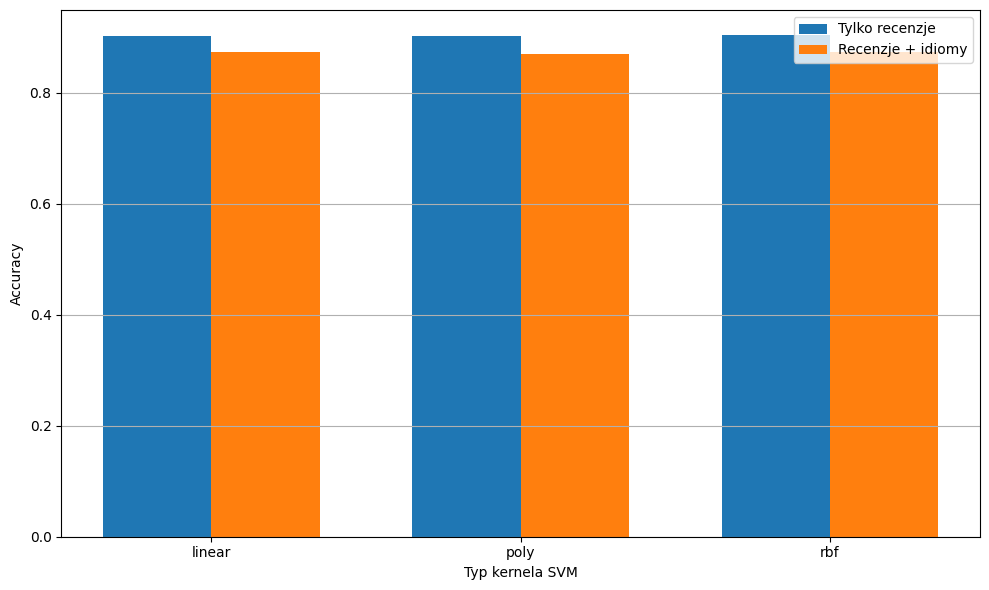


Wyświetlanie macierzy pomyłek dla kernela: linear


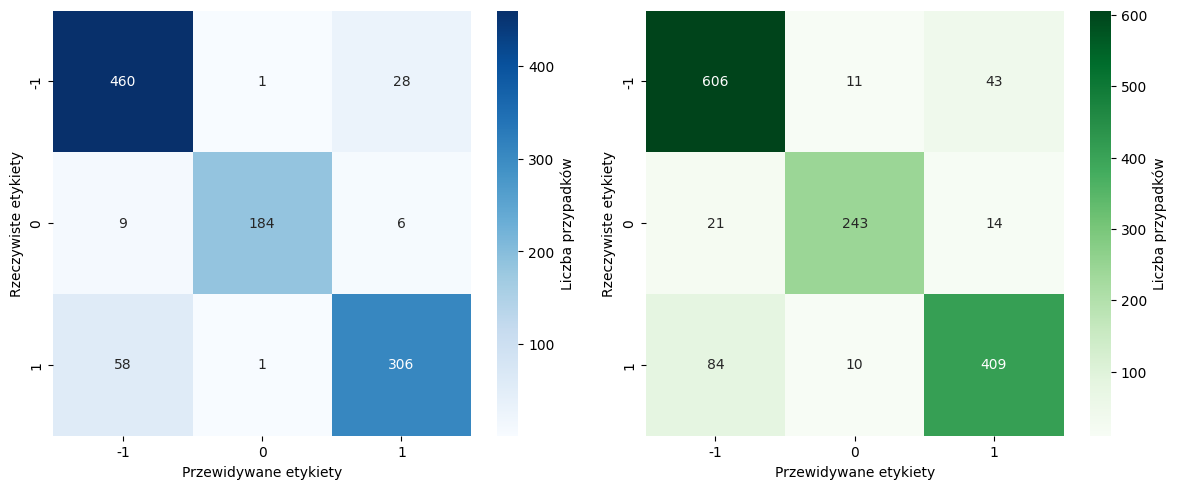


Wyświetlanie macierzy pomyłek dla kernela: poly


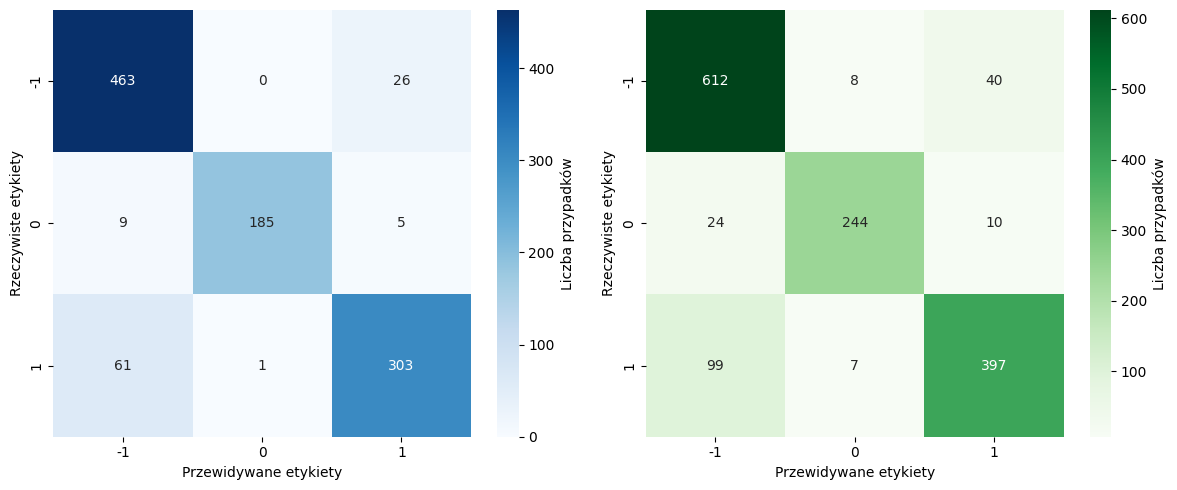


Wyświetlanie macierzy pomyłek dla kernela: rbf


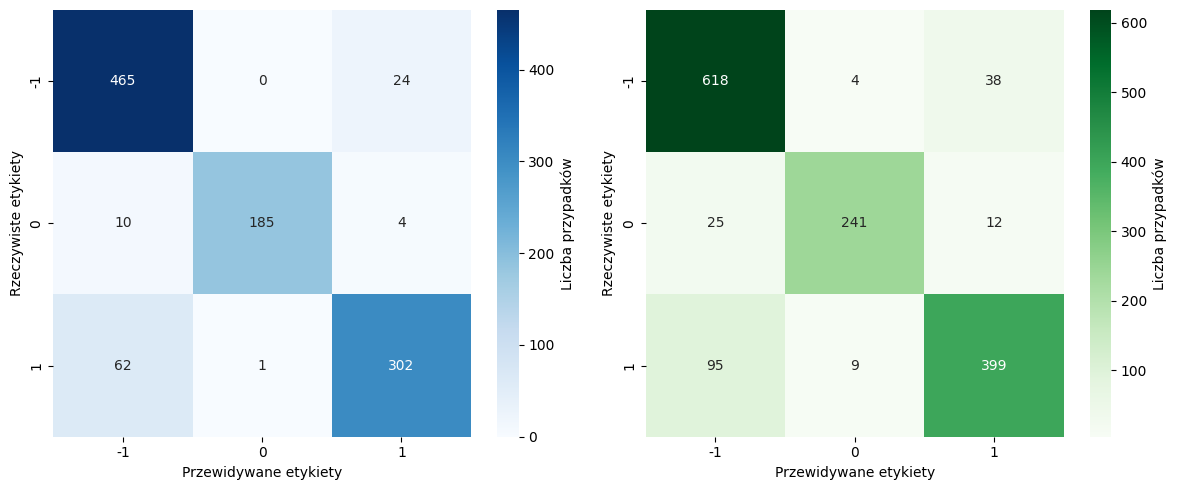


PODSUMOWANIE WYNIKÓW:

LINEAR kernel:
  Tylko recenzje:    0.9022
  Recenzje + idiomy: 0.8730
  Różnica:           -0.0292

POLY kernel:
  Tylko recenzje:    0.9031
  Recenzje + idiomy: 0.8695
  Różnica:           -0.0336

RBF kernel:
  Tylko recenzje:    0.9041
  Recenzje + idiomy: 0.8730
  Różnica:           -0.0311


In [2]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=None, random_state=12)

# Lista kernelów do przetestowania
kernels = ['linear', 'poly', 'rbf']

# Inicjalizacja list na wyniki
acc_reviews = []
acc_reviews_idioms = []
confusion_matrices_reviews = []
confusion_matrices_idioms = []

print("Rozpoczynanie trenowania modeli SVM...")

# Trenowanie i zbieranie wyników
for kernel in kernels:
    print(f"\nTraining SVM (kernel={kernel}) on reviews only...")
    model = SVC(kernel=kernel)
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
    acc_reviews.append(acc)
    confusion_matrices_reviews.append(cm)
    print(f"Done in {time.time() - start:.2f}s, Accuracy: {acc:.4f}")

    print(f"Training SVM (kernel={kernel}) on reviews + idioms...")
    model2 = SVC(kernel=kernel)
    start = time.time()
    model2.fit(X2_train, y2_train)
    y2_pred = model2.predict(X2_test)
    acc2 = accuracy_score(y2_test, y2_pred)
    cm2 = confusion_matrix(y2_test, y2_pred, labels=[-1, 0, 1])
    acc_reviews_idioms.append(acc2)
    confusion_matrices_idioms.append(cm2)
    print(f"Done in {time.time() - start:.2f}s, Accuracy: {acc2:.4f}")

# Wykres porównawczy accuracy
x = np.arange(len(kernels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width/2, acc_reviews, width, label='Tylko recenzje')
bars2 = ax.bar(x + width/2, acc_reviews_idioms, width, label='Recenzje + idiomy')

ax.set_xlabel('Typ kernela SVM')
ax.set_ylabel('Accuracy')
# ax.set_title('Porównanie skuteczności SVM (różne kernela)')
ax.set_xticks(x)
ax.set_xticklabels(kernels)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Funkcja do rysowania macierzy pomyłek
def plot_confusion_matrices(cm_reviews, cm_idioms, kernel_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Macierz dla "tylko recenzje"
    sns.heatmap(cm_reviews, annot=True, fmt='d', cmap='Blues',
                xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1],
                ax=ax1, cbar_kws={'label': 'Liczba przypadków'})
    # ax1.set_title(f'Tylko recenzje - {kernel_name}')
    ax1.set_xlabel('Przewidywane etykiety')
    ax1.set_ylabel('Rzeczywiste etykiety')

    # Macierz dla "recenzje + idiomy"
    sns.heatmap(cm_idioms, annot=True, fmt='d', cmap='Greens',
                xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1],
                ax=ax2, cbar_kws={'label': 'Liczba przypadków'})
    # ax2.set_title(f'Recenzje + idiomy - {kernel_name}')
    ax2.set_xlabel('Przewidywane etykiety')
    ax2.set_ylabel('Rzeczywiste etykiety')

    plt.tight_layout()
    plt.show()

# Sprawdzenie czy listy zostały wypełnione
if len(confusion_matrices_reviews) == 0 or len(confusion_matrices_idioms) == 0:
    print("BŁĄD: Macierze pomyłek nie zostały wygenerowane. Sprawdź czy trenowanie przebiegło pomyślnie.")
    print(f"Długość confusion_matrices_reviews: {len(confusion_matrices_reviews)}")
    print(f"Długość confusion_matrices_idioms: {len(confusion_matrices_idioms)}")
else:
    # Wyświetlenie macierzy pomyłek dla każdego kernela
    for i, kernel in enumerate(kernels):
        print(f"\nWyświetlanie macierzy pomyłek dla kernela: {kernel}")
        plot_confusion_matrices(confusion_matrices_reviews[i],
                              confusion_matrices_idioms[i],
                              kernel.upper())

# # Opcjonalnie: zestawienie wszystkich macierzy na jednym wykresie
# if len(confusion_matrices_reviews) > 0 and len(confusion_matrices_idioms) > 0:
#     fig, axes = plt.subplots(2, 3, figsize=(15, 10))
#     fig.suptitle('Macierze pomyłek dla różnych kerneli SVM', fontsize=16)

#     for i, kernel in enumerate(kernels):
#         # Górny rząd - tylko recenzje
#         sns.heatmap(confusion_matrices_reviews[i], annot=True, fmt='d', cmap='Blues',
#                     xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1],
#                     ax=axes[0, i], cbar=False)
#         axes[0, i].set_title(f'Tylko recenzje - {kernel.upper()}')
#         axes[0, i].set_xlabel('Przewidywane etykiety')
#         if i == 0:
#             axes[0, i].set_ylabel('Rzeczywiste etykiety')

#         # Dolny rząd - recenzje + idiomy
#         sns.heatmap(confusion_matrices_idioms[i], annot=True, fmt='d', cmap='Greens',
#                     xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1],
#                     ax=axes[1, i], cbar=False)
#         axes[1, i].set_title(f'Recenzje + idiomy - {kernel.upper()}')
#         axes[1, i].set_xlabel('Przewidywane etykiety')
#         if i == 0:
#             axes[1, i].set_ylabel('Rzeczywiste etykiety')

#     plt.tight_layout()
#     plt.show()
# else:
#     print("Nie można wyświetlić zestawienia - brak danych macierzy pomyłek.")

# Wyświetlenie dokładnych wyników accuracy
print("\n" + "="*50)
print("PODSUMOWANIE WYNIKÓW:")
print("="*50)
for i, kernel in enumerate(kernels):
    print(f"\n{kernel.upper()} kernel:")
    print(f"  Tylko recenzje:    {acc_reviews[i]:.4f}")
    print(f"  Recenzje + idiomy: {acc_reviews_idioms[i]:.4f}")
    print(f"  Różnica:           {acc_reviews_idioms[i] - acc_reviews[i]:+.4f}")

In [14]:
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# import time
# from collections import Counter

# # Sprawdzenie rozkładu klas w danych
# print("ANALIZA ROZKŁADU KLAS:")
# print("="*40)
# print("Zbiór 1 (tylko recenzje):")
# print(f"Rozkład y: {Counter(y)}")
# print(f"Procenty: {dict(zip(*np.unique(y, return_counts=True)))}")

# print("\nZbiór 2 (recenzje + idiomy):")
# print(f"Rozkład y2: {Counter(y2)}")
# print(f"Procenty: {dict(zip(*np.unique(y2, return_counts=True)))}")

# # Podział danych
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=12, stratify=y2)

# print(f"\nRozkład w zbiorze treningowym (y_train): {Counter(y_train)}")
# print(f"Rozkład w zbiorze testowym (y_test): {Counter(y_test)}")

# # Obliczenie wag klas
# class_weights_1 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights_2 = compute_class_weight('balanced', classes=np.unique(y2_train), y=y2_train)

# print(f"\nWagi klas dla zbioru 1: {dict(zip(np.unique(y_train), class_weights_1))}")
# print(f"Wagi klas dla zbioru 2: {dict(zip(np.unique(y2_train), class_weights_2))}")

# # Lista kernelów do przetestowania
# kernels = ['linear', 'poly', 'rbf']

# # Różne konfiguracje do testowania
# configs = [
#     {'name': 'Domyślne', 'params': {}},
#     {'name': 'Balanced', 'params': {'class_weight': 'balanced'}},
#     {'name': 'Custom C', 'params': {'C': 0.1, 'class_weight': 'balanced'}},
#     {'name': 'Gamma + C', 'params': {'C': 10, 'gamma': 'scale', 'class_weight': 'balanced'}}
# ]

# # Inicjalizacja wyników
# results = {}

# for config in configs:
#     config_name = config['name']
#     params = config['params']
#     results[config_name] = {'reviews': [], 'idioms': [], 'cm_reviews': [], 'cm_idioms': []}

#     print(f"\n{'='*60}")
#     print(f"TESTOWANIE KONFIGURACJI: {config_name}")
#     print(f"Parametry: {params}")
#     print('='*60)

#     for kernel in kernels:
#         print(f"\nKernel: {kernel}")

#         # Model dla recenzji
#         model1 = SVC(kernel=kernel, **params)
#         start = time.time()
#         model1.fit(X_train, y_train)
#         y_pred1 = model1.predict(X_test)
#         acc1 = accuracy_score(y_test, y_pred1)
#         cm1 = confusion_matrix(y_test, y_pred1, labels=[-1, 0, 1])

#         results[config_name]['reviews'].append(acc1)
#         results[config_name]['cm_reviews'].append(cm1)
#         print(f"  Recenzje: Acc={acc1:.4f}, Time={time.time()-start:.2f}s")

#         # Model dla recenzji + idiomy
#         model2 = SVC(kernel=kernel, **params)
#         start = time.time()
#         model2.fit(X2_train, y2_train)
#         y_pred2 = model2.predict(X2_test)
#         acc2 = accuracy_score(y2_test, y_pred2)
#         cm2 = confusion_matrix(y2_test, y2_pred, labels=[-1, 0, 1])

#         results[config_name]['idioms'].append(acc2)
#         results[config_name]['cm_idioms'].append(cm2)
#         print(f"  Recenzje+idiomy: Acc={acc2:.4f}, Time={time.time()-start:.2f}s")

# # Funkcja do rysowania macierzy pomyłek z dodatkowymi informacjami
# def plot_detailed_confusion_matrices(results, kernel_idx, kernel_name):
#     n_configs = len(results)
#     fig, axes = plt.subplots(2, n_configs, figsize=(4*n_configs, 8))

#     if n_configs == 1:
#         axes = axes.reshape(-1, 1)

#     fig.suptitle(f'Macierze pomyłek - {kernel_name} kernel', fontsize=16)

#     for i, (config_name, data) in enumerate(results.items()):
#         # Górny rząd - tylko recenzje
#         cm_rev = data['cm_reviews'][kernel_idx]
#         sns.heatmap(cm_rev, annot=True, fmt='d', cmap='Blues',
#                     xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1],
#                     ax=axes[0, i], cbar=True)
#         acc_rev = data['reviews'][kernel_idx]
#         axes[0, i].set_title(f'Recenzje - {config_name}\nAcc: {acc_rev:.4f}')
#         axes[0, i].set_xlabel('Przewidywane')
#         if i == 0:
#             axes[0, i].set_ylabel('Rzeczywiste')

#         # Dolny rząd - recenzje + idiomy
#         cm_idi = data['cm_idioms'][kernel_idx]
#         sns.heatmap(cm_idi, annot=True, fmt='d', cmap='Greens',
#                     xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1],
#                     ax=axes[1, i], cbar=True)
#         acc_idi = data['idioms'][kernel_idx]
#         axes[1, i].set_title(f'Recenzje+idiomy - {config_name}\nAcc: {acc_idi:.4f}')
#         axes[1, i].set_xlabel('Przewidywane')
#         if i == 0:
#             axes[1, i].set_ylabel('Rzeczywiste')

#     plt.tight_layout()
#     plt.show()

# # Wyświetlenie wyników dla każdego kernela
# for i, kernel in enumerate(kernels):
#     plot_detailed_confusion_matrices(results, i, kernel.upper())

# # Podsumowanie najlepszych wyników
# print("\n" + "="*80)
# print("PODSUMOWANIE NAJLEPSZYCH WYNIKÓW:")
# print("="*80)

# for i, kernel in enumerate(kernels):
#     print(f"\n{kernel.upper()} kernel:")
#     print("-" * 40)

#     best_acc_rev = 0
#     best_config_rev = ""
#     best_acc_idi = 0
#     best_config_idi = ""

#     for config_name, data in results.items():
#         acc_rev = data['reviews'][i]
#         acc_idi = data['idioms'][i]

#         if acc_rev > best_acc_rev:
#             best_acc_rev = acc_rev
#             best_config_rev = config_name

#         if acc_idi > best_acc_idi:
#             best_acc_idi = acc_idi
#             best_config_idi = config_name

#         print(f"{config_name:12}: Rev={acc_rev:.4f}, Rev+Idi={acc_idi:.4f}")

#     print(f"\nNajlepsze dla recenzji: {best_config_rev} ({best_acc_rev:.4f})")
#     print(f"Najlepsze dla rec+idi:  {best_config_idi} ({best_acc_idi:.4f})")

# # Dodatkowa analiza - sprawdzenie czy klasa 0 w ogóle jest przewidywana
# print("\n" + "="*80)
# print("ANALIZA PRZEWIDYWAŃ KLASY NEUTRALNEJ (0):")
# print("="*80)

# best_config = 'Balanced'  # Możesz zmienić na najlepszą konfigurację
# for i, kernel in enumerate(kernels):
#     cm_rev = results[best_config]['cm_reviews'][i]
#     cm_idi = results[best_config]['cm_idioms'][i]

#     pred_0_rev = cm_rev[:, 1].sum()  # Suma kolumny dla klasy 0
#     pred_0_idi = cm_idi[:, 1].sum()

#     print(f"{kernel.upper()} - Przewidziano jako neutralne:")
#     print(f"  Recenzje: {pred_0_rev} próbek")
#     print(f"  Rec+idiomy: {pred_0_idi} próbek")

ANALIZA ROZKŁADU KLAS:
Zbiór 1 (tylko recenzje):
Rozkład y: Counter({1: 5011, -1: 2775, 0: 1191})
Procenty: {-1: 2775, 0: 1191, 1: 5011}

Zbiór 2 (recenzje + idiomy):
Rozkład y2: Counter({1: 5155, -1: 3034, 0: 1288})
Procenty: {-1: 3034, 0: 1288, 1: 5155}

Rozkład w zbiorze treningowym (y_train): Counter({1: 4008, -1: 2220, 0: 953})
Rozkład w zbiorze testowym (y_test): Counter({1: 1003, -1: 555, 0: 238})

Wagi klas dla zbioru 1: {-1: 1.0782282282282283, 0: 2.511717383700595, 1: 0.5972222222222222}
Wagi klas dla zbioru 2: {-1: 1.0412031314379893, 0: 2.4533980582524273, 1: 0.6127546071774975}

TESTOWANIE KONFIGURACJI: Domyślne
Parametry: {}

Kernel: linear
  Recenzje: Acc=0.6943, Time=3.18s


ValueError: Found input variables with inconsistent numbers of samples: [1896, 2370]